In [5]:
import pandas as pd
from pathlib import Path
import os

setup: train_test split, undersampling

In [7]:
import pandas as pd
from pathlib import Path
import os
directory = Path(os.getcwd())   # 'c:\\Users\\samue\\OneDrive\\Desktop\\JPM Fintech\\HKUST-x-J.P.-Morgan-Fintech-Mentorship-Program\\model_testing\\supervised'
directory = directory.parent.parent.parent.joinpath("data")  # 'c:\\Users\\samue\\OneDrive\\Desktop\\JPM Fintech\\data'
df = pd.read_pickle(directory.joinpath("stocktwits_processed_without_multiple_full.pkl"))
df
for i in df.sample(100).text:
    print(i)

 Musk talking about deficit like a business, incomes lower than outflows.  After receiving a 1.5 trillion tax cut for businesses....
 A US State Department official has said that tech companies Alibaba and Tencent should be seen as tools of the Chinese government, along with China’s embattled telecom giant Huawei. It raises the possibility that the US will widen its range of Chinese targets for enhanced scrutiny due to security concerns.
 $1300 before EOY
 I just signed up for prime. may my 12.99 bucks a month help us get better earnings!
 Bye bye 👋
 
The next Amazon EXPI

EXP world holdings
 what the fuck is this!!
 my buddy is up 800% on this since 2016. Never selling don’t be weak lol. This pull back is needed
Will  be around in 10 years? If you answered yes, this is a no brainer BUY right now. Fundamentals are great, the only reason this is dipping is FEAR. Buy while the market is fearful people
 Santa rally b.s.
 short squeeze next year. Let’s go 🍷🍀🙏
 under 90 today?
 oooof
 ;-) 


In [3]:
def setup(sample=1000, ratio=0.8, is_token=True, sample_method=0):
    # set directory
    directory = Path(os.getcwd())   # 'c:\\Users\\samue\\OneDrive\\Desktop\\JPM Fintech\\HKUST-x-J.P.-Morgan-Fintech-Mentorship-Program\\model_testing\\supervised'
    directory = directory.parent.parent.parent.joinpath("data")  # 'c:\\Users\\samue\\OneDrive\\Desktop\\JPM Fintech\\data'
    df = pd.read_pickle(directory.joinpath("stocktwits_processed_without_multiple_full.pkl"))
    
    # remove symbols with too little sample size
    df = df.groupby('symbols').filter(lambda x : len(x)>sample)

    if sample_method == 0:
        # turn all symbols into the same sample size
        i = sample
        for j in set(df['symbols']):
            df = df[df['symbols'] != j].append(df[df['symbols'] == j].sample(i), ignore_index=True)
        #print(df['symbols'].value_counts())
    
    # train_test split
    df_train = df.sample(frac=ratio,random_state=200)
    df_test = df.drop(df_train.index)

    if is_token:
        X_train = df_train.tokens
        X_test = df_test.tokens
    else:
        X_train = df_train.text
        X_test = df_test.text
        
    y_train = df_train.symbols
    y_test = df_test.symbols

    print_str = "{} unique classes\t{} training samples\t{} test samples".format(len(set(y_train)), len(X_train), len(X_test))

    return X_train, X_test, y_train, y_test, print_str

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN,BorderlineSMOTE,KMeansSMOTE,SVMSMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN, SMOTETomek 

@ignore_warnings(category=ConvergenceWarning)
def model(X_train, X_test, y_train, y_test, model_method, sample_method):
    # Build the model
    model = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer())])

    if sample_method == 1:
        #pass
        model.steps.append(['smote', SMOTE()])
    elif sample_method == 2:
        model.steps.append(['ros', RandomOverSampler()])
    elif sample_method == 3:
        model.steps.append(['ada', ADASYN()])
    elif sample_method == 4:
        model.steps.append(['sm', BorderlineSMOTE()])
    elif sample_method == 5:
        model.steps.append(['sm', SVMSMOTE()])
    elif sample_method == 6:
        model.steps.append(['smotteen', SMOTEENN()])
    elif sample_method == 7:
        model.steps.append(['smotetomek', SMOTETomek()])

    if model_method == 0:
        model.steps.append(['clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)])
        #model.steps.append(['clf', SVC()])
        #param_grid = {'clf__C': [10, 100],
              #'clf__gamma': [1],
              #'clf__kernel': ['rbf', 'linear','poly','sigmoid']}

    elif model_method == 1:
        model.steps.append(['clf', MultinomialNB()])
        #param_grid = {
  #'clf__alpha': np.linspace(0.5, 1.5, 6),
  #'clf__fit_prior': [True, False], }
  
    elif model_method == 2:
        model.steps.append(['clf', LogisticRegression(n_jobs=1, C=1e5)])

    #model = GridSearchCV(model, param_grid, n_jobs=2)
    #print(model)
    # Train the model using the training data
    model.fit(X_train, y_train)
    # Predict the symbols of the test data
    y_pred = model.predict(X_test)
    #print(model.best_estimator_)
    # accuracy
    #print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))
    
    # plot the confusion matrix
    mat = confusion_matrix(y_test, y_pred)
    #sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=set(y_train),yticklabels=set(y_train))
    #plt.xlabel("true labels")
    #plt.ylabel("predicted label")
    #plt.show()

    return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred,target_names=set(y_train)), mat

Method 1: random sample

In [37]:
iteration = 10

model_no = 0

for s in [290,500,1000]:
    for r in [0.7]:
        for t in [False]:
            for i in range(0, 1):
                print('sample:{}\tratio:{}\ttoken:{}'.format(s,r,t))
        
                scores = []
                for j in range(iteration):
                    X_train, X_test, y_train, y_test, print_str = setup(s, r, t, model_no)
                    if j == 0:
                        print(print_str)
                    score,a,b, model = model(X_train, X_test, y_train, y_test, i, model_no)
                    scores.append(score)
                print('{}: {}'.format(i, sum(scores)/len(scores)))
                print()

sample:290	ratio:0.7	token:False
12 unique classes	2436 training samples	1044 test samples


TypeError: 'Pipeline' object is not callable

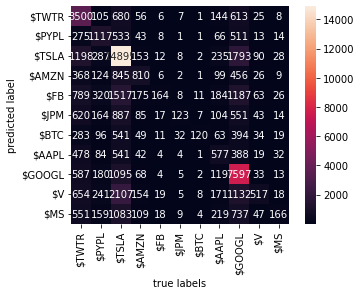

In [56]:
sns.heatmap(b.T, square = True, annot=True, fmt = "d", xticklabels=set(y_train),yticklabels=set(y_train))
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

In [59]:
print(a)

              precision    recall  f1-score   support

       $TWTR       0.82      0.31      0.45      9303
       $PYPL       0.90      0.19      0.31      2877
       $TSLA       0.55      0.98      0.71     24724
       $AMZN       0.83      0.15      0.26      1744
         $FB       0.69      0.09      0.16       269
        $JPM       0.71      0.11      0.19       204
        $BTC       0.63      0.41      0.50       158
       $AAPL       0.74      0.09      0.16      1981
      $GOOGL       0.75      0.45      0.57     15359
          $V       0.58      0.06      0.12       910
         $MS       0.70      0.12      0.20       347

    accuracy                           0.61     57876
   macro avg       0.72      0.27      0.33     57876
weighted avg       0.68      0.61      0.56     57876



In [54]:
print(a)

              precision    recall  f1-score   support

       $TWTR       0.68      0.38      0.48      9303
       $PYPL       0.43      0.39      0.41      2877
       $TSLA       0.80      0.60      0.69     24724
       $AMZN       0.29      0.46      0.36      1744
         $FB       0.04      0.61      0.07       269
        $JPM       0.05      0.60      0.09       204
        $BTC       0.07      0.76      0.13       158
       $AAPL       0.27      0.29      0.28      1981
      $GOOGL       0.78      0.49      0.61     15359
          $V       0.10      0.57      0.17       910
         $MS       0.05      0.48      0.10       347

    accuracy                           0.51     57876
   macro avg       0.32      0.51      0.31     57876
weighted avg       0.70      0.51      0.58     57876



Method 2: with SMOTE

In [58]:
iteration = 1

model_no = 1

for s in [500]:
    for r in [0.7]:
        for t in [False]:
            for i in range(0, 1):
                print('sample:{}\tratio:{}\ttoken:{}'.format(s,r,t))
        
                scores = []
                for j in range(iteration):
                    X_train, X_test, y_train, y_test, print_str = setup(s, r, t, model_no)
                    if j == 0:
                        print(print_str)
                    score,a,b = model(X_train, X_test, y_train, y_test, i, model_no)
                    scores.append(score)
                print('{}: {}'.format(i, sum(scores)/len(scores)))
                print()

sample:500	ratio:0.7	token:False
11 unique classes	135044 training samples	57876 test samples
0: 0.6083868961227452



try various SMOTE

In [49]:
iteration = 1

#model_no = 1

for s in [500]:
    for r in [0.7]:
        for t in [False]:
            for i in range(0, 1):
                for model_no in range(1,2):
                    print('sample:{}\tratio:{}\ttoken:{}'.format(s,r,t))
            
                    scores = []
                    for j in range(iteration):
                        X_train, X_test, y_train, y_test, print_str = setup(s, r, t, model_no)
                        if j == 0:
                            print(print_str)
                        score,a,b = model(X_train, X_test, y_train, y_test, i, model_no)
                        scores.append(score)
                    print('{}: {}'.format(model_no, a))
                    print()

sample:500	ratio:0.7	token:False
10 unique classes	24924 training samples	10682 test samples
1:               precision    recall  f1-score   support

       $PYPL       0.58      0.38      0.46      1637
       $TSLA       0.21      0.58      0.31       248
         $FB       0.35      0.43      0.39      1076
        $JPM       0.13      0.42      0.19       193
       $MSFT       0.34      0.68      0.46       201
       $AAPL       0.26      0.78      0.39       151
         $MS       0.43      0.36      0.39       836
          $V       0.55      0.41      0.47      1283
         $JD       0.80      0.64      0.71      4771
        $BAC       0.25      0.51      0.34       286

    accuracy                           0.53     10682
   macro avg       0.39      0.52      0.41     10682
weighted avg       0.60      0.53      0.55     10682


